In [1]:
import os
import sys
import numpy as np
from numpy.random import randint, choice, randn
import torch
import skimage.morphology
from skimage.morphology import ball, octahedron, cube
from matplotlib import cm
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.distributions as dist
import torch.nn.functional as F
from   scipy.stats import lognorm

In [2]:
def make_ball(r = 20, datasize = [128, 128, 128]):
    data     = np.zeros(datasize)
    datasize = np.array(datasize)
    s        = 'ball' # 'octahedron', 'cube'
    form     = getattr(skimage.morphology, s)(r).astype(np.float32)
    z, x, y  = datasize // 2 - r
    z_max    = min(z + form.shape[0], datasize[0])
    x_max    = min(x + form.shape[1], datasize[1])
    y_max    = min(y + form.shape[2], datasize[2])
    data[z : z + form.shape[0],
         x : x + form.shape[1],
         y : y + form.shape[2],]\
    += \
    form[0 : z_max - z        ,
         0 : x_max - x        ,
         0 : y_max - y        ,]
    data = data > 0
    data = torch.from_numpy(data) * 1.
    data = data.unsqueeze(0)
    return data

In [3]:
data = make_ball(r=20, datasize=[160, 128, 128])
nd_data = data.detach().numpy().copy()

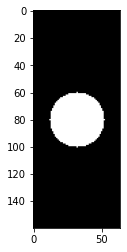

In [4]:
plt.imshow(data[0, :, 64, 32:96], cmap='gray', vmax=1, vmin=0)

In [38]:
class Emission(nn.Module):
    def __init__(self, mu_z, sig_z, log_ez0):
        super().__init__()
        self.mu_z     = mu_z
        self.sig_z    = sig_z
        self.log_ez0  = log_ez0
        #self.mu_z_    = mu_z.item()
        #self.sig_z_   = sig_z.item()
        #self.logn_ppf = lognorm.ppf([0.99], 1,
        #                    loc=self.mu_z_, scale=self.sig_z_)[0]
        
    def sample(self, x):
        b = x.shape[0]
        pz0  = dist.LogNormal(loc   = self.mu_z.view( b, 1, 1, 1, 1).expand(*x.shape),
                              scale = self.sig_z.view(b, 1, 1, 1, 1).expand(*x.shape),)
        x    = x * pz0.sample().to(x.device)
        x    = torch.clip(x, min=0, max=1)
        #x    = x / self.logn_ppf
        return x

    def forward(self, x):
        x = x * torch.exp(self.log_ez0)
        x = torch.clip(x, min=0, max=1)
        #x   = x / self.logn_ppf
        return x


class Intensity(nn.Module):
    def __init__(self, gamma, image_size, initial_depth, voxel_size, scale,
                 device):
        super().__init__()
        init_d = initial_depth
        im_z,  \
        im_x,  \
        im_y   = image_size
        end_d  = im_z * voxel_size * scale
        depth  = init_d \
               + torch.linspace(0, end_d, im_z,).view(-1,1,1,).to(device)
        _intensity = torch.exp(-2 * depth * gamma) # gamma = 0.005
        self._intensity = _intensity.expand(image_size)

    def forward(self, x):
         x = x * self.intensity
         return x

    @property
    def intensity(self):
        return self._intensity


class Blur(nn.Module):
    def __init__(self, z, x, y, log_bet_z, log_bet_xy, log_alpha, scale, device,
                 psf_mode:str="double_exp"):
        super().__init__()
        self.log_bet_z   = log_bet_z
        self.log_bet_xy  = log_bet_xy
        self.log_alpha   = log_alpha
        self.zscale, \
        self.xscale, \
        self.yscale  = scale
        self.z       = z
        self.x       = x
        self.y       = y
        self.device  = device
        self.zd      = self.distance(z)
        self.dp      = self.gen_distance_plane(xlen=x, ylen=y)
        self.mode    = psf_mode
        bet_xy       = torch.exp(self.log_bet_xy)
        bet_z        = torch.exp(self.log_bet_z )
        alpha        = torch.exp(self.log_alpha )
        self.psf     = self.gen_psf(bet_xy, bet_z, alpha).to(device)
        self.z_pad   = (z - self.zscale + 1) // 2
        self.x_pad   = (x - self.xscale + 1) // 2
        self.y_pad   = (y - self.yscale + 1) // 2
        self.stride  = (self.zscale, self.xscale, self.yscale)
        print(self.stride)
    
    def forward(self, x):
        x_shape = x.shape
        bet_xy  = torch.exp(self.log_bet_xy)
        bet_z   = torch.exp(self.log_bet_z )
        alpha   = torch.exp(self.log_alpha )
        psf = self.gen_psf(bet_xy, bet_z, alpha).to(self.device)
        _x   = F.conv3d(input   = x                                    ,
                        weight  = psf                                  ,
                        stride  = self.stride                          ,
                        padding = (self.z_pad, self.x_pad, self.y_pad,),)
        batch = _x.shape[0]
        x = torch.empty(size=(*x_shape[:2], *_x.shape[2:])).to(self.device)
        for b in range(batch):
                x[b, 0] = _x[b, b]
        return x

    def gen_psf(self, bet_xy, bet_z, alpha):
        if bet_xy.shape:
            b = bet_xy.shape[0]
        else:
            b = 1
        psf_lateral = self.gen_2dnorm(self.dp, bet_xy, b)[:, None, None,    :,    :]
        psf_axial   = self.gen_1dnorm(self.zd, bet_z , b)[:, None,    :, None, None]
        psf  = torch.exp(torch.log(psf_lateral) + torch.log(psf_axial)) # log-sum-exp technique
        if self.mode == "gaussian":
            pass
        elif self.mode == "double_exp":
            if not alpha.shape:
                alpha = alpha.unsqueeze(0)
            psf  = self.gen_double_exp_dist(psf, alpha[:, None, None, None, None],)
        psf /= torch.sum(psf)
        return psf

    def _init_distance(self, length):
        return torch.zeros(length)

    def _distance_from_center(self, index, length):
        return abs(index - length // 2)

    def distance(self, length):
        distance = torch.zeros(length)
        for idx in range(length):
            distance[idx] = self._distance_from_center(idx, length)
        return distance.to(self.device)

    def gen_distance_plane(self, xlen, ylen):
        xd = self.distance(xlen)
        yd = self.distance(ylen)
        xp = xd.expand(ylen, xlen)
        yp = yd.expand(xlen, ylen).transpose(1, 0)
        dp = xp ** 2 + yp ** 2
        return dp.to(self.device)

    def gen_2dnorm(self, distance_plane, bet_xy, b):
        distance_plane = distance_plane.expand(b, *distance_plane.shape)
        bet_xy = bet_xy.view(b, 1, 1).expand(*distance_plane.shape)
        d_2      =  distance_plane / bet_xy ** 2
        normterm = (torch.pi * 2) * (bet_xy ** 2)
        norm     = torch.exp(-d_2 / 2) / normterm
        return norm

    def gen_1dnorm(self, distance, bet_z, b):
        distance = distance.expand(b, *distance.shape)
        bet_z = bet_z.view(b, 1).expand(*distance.shape)
        d_2      =  distance ** 2 / bet_z ** 2
        normterm = (torch.pi * 2) ** 0.5 * bet_z
        norm     = torch.exp(-d_2 / 2) / normterm
        return norm

    def gen_double_exp_dist(self, norm, alpha,):
        pdf  = 1. - torch.exp(-alpha * norm)
        return pdf


class Noise(nn.Module):
    def __init__(self, sig_eps):
        super().__init__()
        self.sig_eps = sig_eps

    def forward(self, x):
        return x
    
    def sample(self, x):
        b = x.shape[0]
        px = dist.Normal(loc   = x           ,
                         scale = self.sig_eps.view(b, 1, 1, 1, 1).expand(*x.shape).to(x.device))
        x  = px.rsample()
        x  = torch.clip(x, min=0, max=1)
        return x


class PreProcess(nn.Module):
    def __init__(self, min, max):
        super().__init__()
        self.min = min
        self.max = max

    def forward(self, x):
        x = torch.clip(x, min=self.min, max=self.max)
        x = (x - self.min) / (self.max - self.min)
        return x


class ImagingProcess(nn.Module):
    def __init__(self, device, params,
                 z, x, y, postmin=0., postmax=1.,
                 mode:str="train",):
        super().__init__()
        self.device = device
        self.z = z
        self.x = x
        self.y = y
        self.postmin = postmin
        self.postmax = postmax
        if mode == "train":
            self.mu_z   = torch.tensor(params["mu_z"])
            self.sig_z  = torch.tensor(params["sig_z"])
            self.log_ez0 = nn.Parameter((torch.tensor(params["mu_z"] + 0.5 * params["sig_z"] ** 2)).to(device), requires_grad=True)
            self.log_bet_z  = nn.Parameter(torch.tensor(params["log_bet_z" ]).to(device), requires_grad=True)
            self.log_bet_xy = nn.Parameter(torch.tensor(params["log_bet_xy"]).to(device), requires_grad=True)
            self.log_alpha  = nn.Parameter(torch.tensor(params["log_alpha" ]).to(device), requires_grad=True)
        elif mode == "dataset":
            self.mu_z    = nn.Parameter(torch.tensor(params["mu_z"  ]), requires_grad=False)
            self.sig_z   = nn.Parameter(torch.tensor(params["sig_z" ]), requires_grad=False)
            self.log_bet_z   = nn.Parameter(torch.tensor(params["log_bet_z" ]), requires_grad=False)
            self.log_bet_xy  = nn.Parameter(torch.tensor(params["log_bet_xy"]), requires_grad=False)
            self.log_alpha   = nn.Parameter(torch.tensor(params["log_alpha" ]), requires_grad=False)
        else:
            raise(NotImplementedError())
        scale = [params["scale"], 1, 1]
        self.emission   = Emission(mu_z    = self.mu_z ,
                                   sig_z   = self.sig_z,
                                   log_ez0 = self.log_ez0,)
        self.blur       = Blur(z           = z              ,
                               x           = x              ,
                               y           = y              ,
                               log_bet_z   = self.log_bet_z ,
                               log_bet_xy  = self.log_bet_xy,
                               log_alpha   = self.log_alpha ,
                               scale       = scale          ,
                               device      = device         ,)
        self.noise      = Noise(torch.tensor(params["sig_eps"]))
        self.preprocess = PreProcess(min=postmin, max=postmax)

    def forward(self, x):
        x = self.emission(x)
        x = self.blur(x)
        x = self.preprocess(x)
        return x

    def sample(self, x):
        x = self.emission.sample(x)
        x = self.blur(x)
        x = self.noise.sample(x)
        x = self.preprocess(x)
        return x
    
    def sample_from_params(self, x, params):
        if isinstance(params["scale"], torch.Tensor):
            z = int(params["scale"][0])
        else:
            z = params["scale"]
        scale = [z, 1, 1] ## use only one scale
        emission   = Emission(tt(params["mu_z"]), tt(params["sig_z"]))
        blur       = Blur(self.z, self.x, self.y,
                          tt(params["log_bet_z"]), tt(params["log_bet_xy"]),
                          tt(params["log_alpha"]), scale, self.device)
        noise      = Noise(tt(params["sig_eps"]))
        preprocess = PreProcess(min=self.postmin, max=self.postmax)
        x = emission.sample(x)
        x = blur(x)
        x = noise.sample(x)
        x = preprocess(x)
        return x

In [60]:
def normalize(array):
    return array / torch.sum(array)

def train_loop(obj, model, label_lateral, label_axial, optimizer, epoch):
    for _ in range(epoch):
        if obj.dim() == 4:
            obj = obj.unsqueeze(0)
        x = model(obj)
        if x.dim() == 5:
            x = x.squeeze(0)
        loss = 
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()
        log_ez0, bet_z, bet_xy, alpha = [i for i in model.parameters()]
        print(f'epoch {_}, loss {loss:.8f}, log_ez0 {log_ez0.item():.6f}, log_bet_xy {bet_xy.item():.6f}, log_bet_z {bet_z.item():.6f}, log_alpha {alpha.item():.6f}')if _ % 10 == 0 else 0

In [50]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
axial = np.load('beadsdataarray/axial.npy')
axial = torch.tensor(axial).to(device)
label_axial = normalize(axial)
lateral = np.load('beadsdataarray/lateral.npy')
lateral = torch.tensor(lateral).to(device)
label_lateral = normalize(lateral)

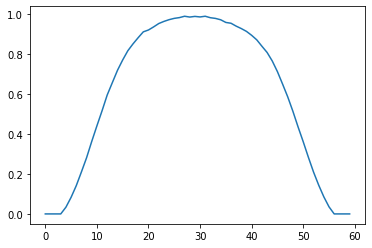

In [51]:
plt.plot(lateral.detach().cpu().numpy())

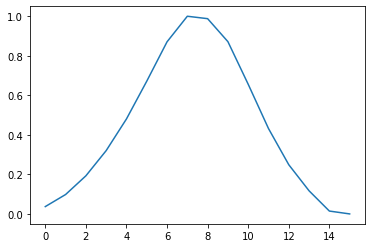

In [52]:
plt.plot(axial.detach().cpu().numpy())

In [64]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
obj = data.to(device)
scale_factor = [10, 1, 1]
z = 101
x = 35
y = 35
mu_z   = 0.2
sig_z  = 0.2
bet_z = 0.276344
bet_xy  = 0.510952
alpha  = 0.031800
params = {"mu_z"       : 0.2    ,
          "sig_z"      : 0.2    ,
          "log_bet_z"  : np.log(23.5329).item(),
          "log_bet_xy" : np.log(1.00000).item(),
          "log_alpha"  : np.log(0.9544 ).item(),
          "sig_eps"    : 0.01   ,
          "scale"      : 10
          }
blur = ImagingProcess(device       = device           ,
                      params       = params           ,
                      z            = z                ,
                      x            = x                ,
                      y            = y                ,
                      mode         = "train"          ,
                      )
init_log_ez0 = (torch.tensor(params["mu_z"]) + 0.5 \
                * torch.tensor(params["sig_z"]) ** 2).to(device)
blur.emission.log_ez0.data = init_log_ez0
blur.blur.log_bet_xy.data  = torch.tensor(params["log_bet_xy"]).to(device)
blur.blur.log_bet_z.data   = torch.tensor(params["log_bet_z"]).to(device)
blur.blur.log_alpha.data   = torch.tensor(params["log_alpha"]).to(device)
optimizer = torch.optim.Adam(blur.parameters(), lr=1e-4)

(10, 1, 1)


In [62]:
[i for i in blur.parameters()]

[Parameter containing:
 tensor(0.2200, device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor(3.1584, device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor(0., device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor(-0.0467, device='cuda:0', requires_grad=True)]

In [65]:
train_loop(obj, blur, label_lateral, label_axial, optimizer, 1000)

epoch 0, loss 0.00201452, log_ez0 0.220000, log_bet_xy nan, log_bet_z 3.158499, log_alpha -0.046573
epoch 10, loss nan, log_ez0 nan, log_bet_xy nan, log_bet_z nan, log_alpha nan


KeyboardInterrupt: 

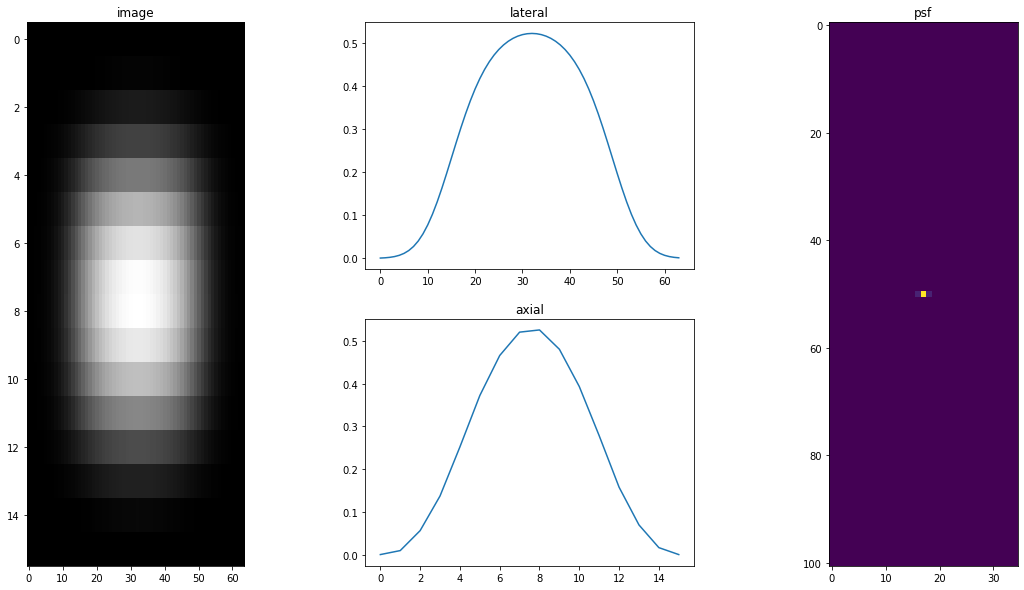

In [18]:
x = data.to(device)
x = blur(x)

x = x.to('cpu')
x_img = x[0, :, 64, 32:96]
x_img = x_img.detach()
fig = plt.figure(figsize=(20, 10))

ax1 = fig.add_subplot(131, title='image')
ax2 = fig.add_subplot(232, title='lateral')
ax3 = fig.add_subplot(235, title='axial')
ax4 = fig.add_subplot(133, title='psf')

ax1.imshow(x_img, aspect=10, vmin=0, vmax=torch.max(x).item(),cmap='gray')
ax2.plot(x_img[7])
ax3.plot(x_img[:, 30])
psf = blur.blur.psf[0, 0, :, 11, :].detach().to('cpu').numpy().copy()
ax4.imshow(psf, vmin=0)
plt.show()